In [1]:
import argparse
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['savefig.dpi'] = 300

import sys
sys.path.append("..")
from utilities import *
from torchdiffeq import odeint

# Nonlinear gradient flow
For this example, the observed data is collected on solution trajectories to
\begin{align*}
\dot x_1 &= -\cos(x_1)\cos(x_2),\\
\dot x_2 &= \sin(x_1)\sin(x_2).
\end{align*}
This is of form $\dot x= -\nabla f(x)$ with
\begin{equation*}
f(x_1, x_2) = \sin(x_1)\cos(x_2). 
\end{equation*}
This system has three types of nodes -- stable nodes, unstable nodes, and saddle points -- spread over the domain in a staggered pattern. Stable nodes at $[(k_1+\frac{1}{2})\pi, k_2\pi]$ where $k_1$ and $k_2$ have opposite parity; unstable nodes at $[(k_1+\frac{1}{2})\pi, k_2\pi]$ where $k_1$ and $k_2$ have the same parity; saddle points at $[k_3\pi, (k_4+\frac{1}{2})\pi]$. The training data consists of $24$ trajectories sampled from domain $[-6,6]\times[-4,6]$ with time interval $[0,8]$ and $\Delta t=0.05$. The neural network $G$ used to approximate $f$ has $2$ hidden layers of $200$ neurons.

In [2]:
def get_parser():
    parser = argparse.ArgumentParser('Nonlinear gradient flow')
    parser.add_argument('--model_true', type=str, choices=['LGF', 'NGF', 'Pendulum', 'Lorenz'], default='NGF')
    parser.add_argument('--model_ocn', type=str, choices=['OCN', 'OCN_GF'], default='OCN_GF')
    parser.add_argument('--train_time', type=float, default=8)
    parser.add_argument('--step_size', type=int, default=0.05)
    parser.add_argument('--batch_size', type=int, default=2)
    parser.add_argument('--test_time', type=int, default=8)
    parser.add_argument('--hidden_layers', type=int, default=2)
    parser.add_argument('--hidden_neurons', type=int, default=200)
    return parser

In [3]:
parser = get_parser()
args = parser.parse_args("")
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
ckpt = torch.load('checkpoint/pretrained/NGF-G2x200-T8.0-bs2', map_location=torch.device('cpu'))

In [7]:
model_true = eval(args.model_true)
model_ocn = eval(args.model_ocn)
y0 = initial_point(args, device)

trf = model_true()
ocn = model_ocn(args)
ocn.load_state_dict(ckpt['params'])

true_y_train, train_t = build_dataset(args, model_true=model_true, data_type='train', y0=y0, device=device)
pred_y_train = odeint(ocn, y0, train_t, method="dopri5")

train_tt = train_t.cpu().numpy()
true_train_yy = true_y_train.cpu().detach().numpy()
pred_train_yy = pred_y_train.cpu().detach().numpy()

## Training results

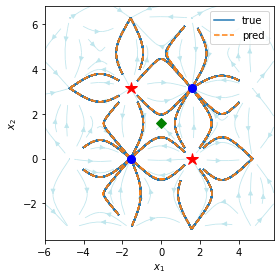

In [5]:
x = np.arange(-6, 6, 0.2)
y = np.arange(-3, 7, 0.2)
  
# Meshgrid
X,Y = np.meshgrid(x,y)
  
# Assign vector directions
Ex = - np.cos(X) * np.cos(Y)
Ey = np.sin(X) * np.sin(Y)
  
# Depict illustration
plt.figure(figsize=(4,4))
#plt.title('Vector field')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.streamplot(X,Y,Ex,Ey, density=0.7, linewidth=0.8, color=(.75,.90,.93))

plt.plot(true_train_yy[:,0,0], true_train_yy[:,0,1], '-', color='C0', label='true')
plt.plot(pred_train_yy[:,0,0], pred_train_yy[:,0,1], '--', markersize=6, color='C1', label='pred')

for i in range(1, len(y0)):
    plt.plot(true_train_yy[:,:,0], true_train_yy[:,:,1], '-', color='C0')
    plt.plot(pred_train_yy[:,:,0], pred_train_yy[:,:,1], '--', markersize=6, color='C1')

# stable nodes
plt.plot(np.pi/2, np.pi, 'b', marker='o', markersize=8)
plt.plot(-np.pi/2, 0, 'b', marker='o', markersize=8)

# unstable nodes
plt.plot(-np.pi/2, np.pi, 'r*', markersize=12)
plt.plot(np.pi/2, 0, 'r*', markersize=12)

# saddle points
plt.plot(0, np.pi/2, 'g', marker='D', markersize=7)

plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('plots/ngf_train')

We observe that for trajectories around different types of nodes, either diverging from sources or converging to sinks, OCN fits the training data well. 

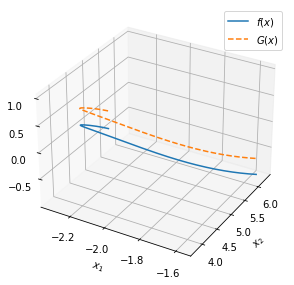

In [8]:
from mpl_toolkits import mplot3d

plt.figure(figsize=(4,4))
ax_func= plt.axes(projection='3d')
ax_func.zaxis._axinfo['juggled'] = (-2,-2,2)
#ax_func.set_title('Learned Function')
ax_func.set_xlabel(r'$x_1$')
ax_func.set_ylabel(r'$x_2$')
ax_func.plot3D(true_train_yy[:,0,0], true_train_yy[:,0,1], trf.F(true_train_yy)[:,0], color='C0', label=r'$f(x)$')
ax_func.plot3D(true_train_yy[:,0,0], true_train_yy[:,0,1], -ocn.F(true_y_train).detach().numpy()[:,0], '--', color='C1', label=r'$G(x)$')
plt.legend()

plt.grid(linestyle='--')
plt.tight_layout()
#plt.savefig('plots/ngf_func')

This is a comparison between the true governing function $f(x)$ and the trained neural network $G(x,\cdot)$, where $x$ represents the training data set $\{x_i\}$. There is a distance between them because the original problem is uniquely determined by $f+c$ for any constant $c$. For $G(x,\cdot)$ that satisfies the original problem, $G(x,\cdot)+c$ also satisfies the original problem for any constant $c$. 

# Testing results
The test data is composed of $8$ initial points, among which $4$ initial points (in the center of the figure) correspond to trajectories that have a similar pattern to that of the training data; another $4$ initial points correspond to trajectories whose dynamic behavior is different from that of the training data. For both types of initial points, OCN recovers the true trajectories well. 

In [9]:
test_y0 = torch.tensor([[-1.2, 3], [1.5, 0], [0.8, 5.6], [-1.3, -3], [-4.1, 0.7], [4.3, 2.6], [1.6, 0.2], [-1.7, 2.8]])
test_y0.requires_grad = True

true_y_test, test_t = build_dataset(args, model_true=model_true, data_type='test', y0=test_y0, device=device)
pred_y_test = odeint(ocn, test_y0, test_t, method="dopri5")

test_tt = test_t.cpu().numpy()
true_test_yy = true_y_test.cpu().detach().numpy()
pred_test_yy = pred_y_test.cpu().detach().numpy()

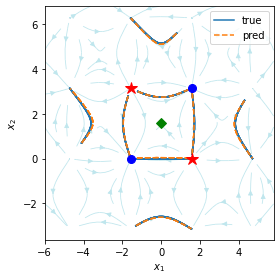

In [10]:
# 1D arrays
x = np.arange(-6, 6, 0.2)
y = np.arange(-3, 7, 0.2)
  
# Meshgrid
X,Y = np.meshgrid(x,y)
  
# Assign vector directions
Ex = - np.cos(X) * np.cos(Y)
Ey = np.sin(X) * np.sin(Y)
  
# Depict illustration
plt.figure(figsize=(4,4))
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.streamplot(X,Y,Ex,Ey, density=0.7, linewidth=0.8, color=(.75,.90,.93))

plt.plot(true_test_yy[:,0,0], true_test_yy[:,0,1], '-', color='C0', label='true')
plt.plot(pred_test_yy[:,0,0], pred_test_yy[:,0,1], '--', markersize=6, color='C1', label='pred')

for i in range(1, len(test_y0)):
    plt.plot(true_test_yy[:,:,0], true_test_yy[:,:,1], '-', color='C0')
    plt.plot(pred_test_yy[:,:,0], pred_test_yy[:,:,1], '--', markersize=6, color='C1')

# stable nodes
plt.plot(np.pi/2, np.pi, 'b', marker='o', markersize=8)
plt.plot(-np.pi/2, 0, 'b', marker='o', markersize=8)

# unstable nodes
plt.plot(-np.pi/2, np.pi, 'r*', markersize=12)
plt.plot(np.pi/2, 0, 'r*', markersize=12)

# saddle points
plt.plot(0, np.pi/2, 'g', marker='D', markersize=7)

plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('plots/ngf_test')